In [1]:
import os
import csv
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import math
import multiprocessing
import time

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torchvision import datasets

In [2]:
DATA_PATH = os.path.join('./noodles_dataset_3k/')
print(os.listdir(DATA_PATH))

# use gpu if you have
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print ("MPS device is available. Successfully initiated:")
    print (x)
    device = mps_device
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available.")
    print("GPU device count:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = torch.device("cpu")

print("Use device:",device)

# set random seed
SEED = int(time.time())
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
multiprocessing.set_start_method("fork")

['test', 'train']
GPU is available.
GPU device count: 1
Current GPU device: 0
GPU device name: NVIDIA GeForce RTX 3060
Use device: cuda:0


In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15,expand = True),
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [4]:
# Specify the path to the training folder.
TRAINDATA_PATH = os.path.join('.','noodles_dataset_3k','train')
# print(TRAINDATA_PATH)
label_name = {"0_spaghetti": 0, "1_ramen": 1, "2_udon": 2}

def get_img_info(data_dir):
        imgpath = []
        imglabel = []
        for root, dirs, _ in os.walk(data_dir):
            # print("root: ", root)
            # print("dirs: ", dirs)
            # Traverse categories
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # Traverse images
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    imgpath.append(path_img)
                    imglabel.append(int(label))

        # Return image paths and labels in data_info
        return imgpath,  imglabel

imgpath,  imglabel = get_img_info(TRAINDATA_PATH)

In [5]:
class Custom_dataset(Dataset):
    def __init__(self,trainData,trainLabel,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.images = trainData
        self.label = trainLabel
        self.transform = transform

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.images[index]
        img = Image.open(imgpath).convert('RGB')

        label = self.label[index]
        if self.transform:
          img = self.transform(img)

        return img, label

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.images)

In [6]:
# Spilt the train and valid data
train_img, val_img, train_label, val_label = train_test_split(imgpath, imglabel, test_size=0.2, random_state=42)

train_set = Custom_dataset(train_img, train_label, transform=train_transform)
valid_set = Custom_dataset(val_img, val_label, transform=valid_transform)

print('Number of total training data:', len(train_set))
print('Number of total validation data:', len(valid_set))

class_num = 3
classes = ("spaghetti", "ramen", "udon")

# Loaded Datasets to DataLoaders
# please change the batch_size
trainloader = DataLoader(train_set, batch_size=16 , shuffle=True, num_workers = 0)
validloader = DataLoader(valid_set, batch_size=16 , shuffle=False, num_workers = 0)

Number of total training data: 6767
Number of total validation data: 1692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([16, 3, 224, 224])
Image label dimensions: torch.Size([16])


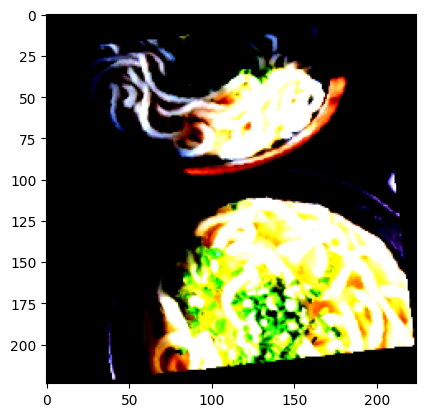

Image batch dimensions:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 torch.Size([16, 3, 224, 224])
Image label dimensions: torch.Size([16])


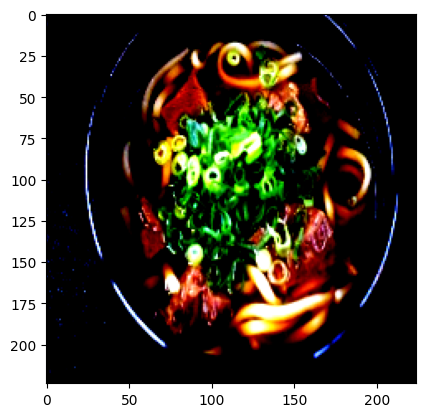

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Checking the dataset
for images, labels in trainloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img,labels in trainloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img = np.transpose(img, (1,2,0))
#show the image
plt.imshow(img)
plt.show()

for images, labels in validloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img_test,labels in validloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img_test = img_test.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img_test = np.transpose(img_test, (1,2,0))
#show the image
plt.imshow(img_test)
plt.show()

In [8]:
##############################################
# Build your model here!
#
# Practice:
#   Try to implement VGG-16 with pytorch !
##############################################
class xception(nn.Module):
    def __init__(self):
        super(xception, self).__init__()

    def three(in_channel, out_channel):

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        ##############################################################################
        #                          TODO: implement VGG-16.                           #
        ##############################################################################
        self.conv_block = nn.Sequential(
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(3,  64, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(512),
            # nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0,2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )
#---------------------------------------------------------------------------------------------------------------------------
        self.feat_classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(0, 2),
            nn.ReLU(),


            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.Dropout(0, 2),
            nn.LeakyReLU(),


            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0, 2),
            nn.ReLU(),


            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0, 2),
            nn.ReLU(),


            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),


            nn.Linear(256, 128),
            nn.Dropout(0,2),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            
            nn.Linear(128, class_num),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.feat_classifier(x)
        return x

model = VGG16()
model.to(device)

VGG16(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0, inplace=2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0, inplace=2)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout(p=0, inplace=2)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Dropout(p=0, inplace=2)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [9]:
print("device: ",device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()

device:  cuda:0


VGG16(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0, inplace=2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0, inplace=2)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout(p=0, inplace=2)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Dropout(p=0, inplace=2)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [10]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
           Dropout-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
           Dropout-6         [-1, 64, 224, 224]               0
       BatchNorm2d-7         [-1, 64, 224, 224]             128
         LeakyReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
          Dropout-11        [-1, 128, 112, 112]               0
      BatchNorm2d-12        [-1, 128, 112, 112]             256
        LeakyReLU-13        [-1, 128, 112, 112]               0
           Conv2d-14        [-1, 128, 1

In [11]:
# WEIGHT_PATH = 'Saving_Path/model_weight.pth'
# checkpoint = torch.load(WEIGHT_PATH , map_location="cuda:0")
# model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
# Training model
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

# Specify the saving weight path
SAVING_PATH = './Saving_Path'

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):# loop over the dataset multiple times

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))

    # train the model
    model.train()
    train_correct = 0
    train_total = 0
    for data, target in tqdm(trainloader):
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
      # update training Accuracy
      train_total += target.size(0)
      _, predicted = torch.max(output.data, 1)
      train_correct += (predicted == target).sum().item()


    # validate the model
    model.eval()
    valid_correct = 0
    valid_total = 0
    for data, target in tqdm(validloader):
        # move tensors to GPU if CUDA is available
        target = target.long()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        valid_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    # print training/validation statistics
    print('Training Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(train_loss,(100 * train_correct / train_total)))
    print('Validation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(valid_loss,(100 * valid_correct / valid_total)))

    train_loss_list.append(train_loss)
    train_acc_list.append(100 * train_correct / train_total)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(100 * valid_correct / valid_total)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), SAVING_PATH+'/model_weight.pth')
        valid_loss_min = valid_loss

print('Finished Training')

running epoch: 1


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.654280 	Training Accuracy: 89.537461
Validation Loss: 0.654825 	Validation Accuracy: 89.479905
Validation loss decreased (inf --> 0.654825).  Saving model ...
running epoch: 2


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.653374 	Training Accuracy: 89.478351
Validation Loss: 0.667528 	Validation Accuracy: 88.356974
running epoch: 3


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.657118 	Training Accuracy: 89.168021
Validation Loss: 0.663288 	Validation Accuracy: 88.593381
running epoch: 4


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.660951 	Training Accuracy: 88.857692
Validation Loss: 0.672049 	Validation Accuracy: 87.470449
running epoch: 5


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.653112 	Training Accuracy: 89.581794
Validation Loss: 0.677576 	Validation Accuracy: 86.879433
running epoch: 6


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.654572 	Training Accuracy: 89.389685
Validation Loss: 0.662681 	Validation Accuracy: 88.711584
running epoch: 7


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.654731 	Training Accuracy: 89.419240
Validation Loss: 0.665654 	Validation Accuracy: 88.238771
running epoch: 8


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.649497 	Training Accuracy: 89.966012
Validation Loss: 0.660673 	Validation Accuracy: 89.125296
running epoch: 9


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.653253 	Training Accuracy: 89.655682
Validation Loss: 0.648046 	Validation Accuracy: 89.952719
Validation loss decreased (0.654825 --> 0.648046).  Saving model ...
running epoch: 10


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.647093 	Training Accuracy: 90.291119
Validation Loss: 0.664119 	Validation Accuracy: 88.829787
running epoch: 11


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.651236 	Training Accuracy: 89.803458
Validation Loss: 0.665939 	Validation Accuracy: 88.416076
running epoch: 12


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.648807 	Training Accuracy: 90.025122
Validation Loss: 0.665957 	Validation Accuracy: 88.416076
running epoch: 13


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.647499 	Training Accuracy: 90.172898
Validation Loss: 0.719538 	Validation Accuracy: 82.565012
running epoch: 14


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.652841 	Training Accuracy: 89.507906
Validation Loss: 0.658679 	Validation Accuracy: 89.361702
running epoch: 15


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.661794 	Training Accuracy: 88.562140
Validation Loss: 0.657358 	Validation Accuracy: 89.243499
running epoch: 16


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.651899 	Training Accuracy: 89.862568
Validation Loss: 0.650978 	Validation Accuracy: 89.598109
running epoch: 17


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.649216 	Training Accuracy: 90.025122
Validation Loss: 0.671879 	Validation Accuracy: 87.411348
running epoch: 18


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.643695 	Training Accuracy: 90.616226
Validation Loss: 0.657745 	Validation Accuracy: 88.888889
running epoch: 19


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.647134 	Training Accuracy: 90.202453
Validation Loss: 0.660719 	Validation Accuracy: 89.302600
running epoch: 20


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.645128 	Training Accuracy: 90.542338
Validation Loss: 0.658536 	Validation Accuracy: 88.829787
running epoch: 21


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.647712 	Training Accuracy: 90.099010
Validation Loss: 0.728806 	Validation Accuracy: 81.737589
running epoch: 22


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.648654 	Training Accuracy: 89.892124
Validation Loss: 0.651485 	Validation Accuracy: 90.070922
running epoch: 23


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.642625 	Training Accuracy: 90.557115
Validation Loss: 0.658096 	Validation Accuracy: 89.302600
running epoch: 24


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.647945 	Training Accuracy: 90.025122
Validation Loss: 0.649084 	Validation Accuracy: 90.130024
running epoch: 25


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.652327 	Training Accuracy: 89.626127
Validation Loss: 0.666324 	Validation Accuracy: 88.238771
running epoch: 26


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.649276 	Training Accuracy: 89.995567
Validation Loss: 0.661807 	Validation Accuracy: 88.652482
running epoch: 27


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.649318 	Training Accuracy: 89.773903
Validation Loss: 0.654832 	Validation Accuracy: 89.302600
running epoch: 28


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.640933 	Training Accuracy: 91.089109
Validation Loss: 0.657646 	Validation Accuracy: 89.066194
running epoch: 29


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.639474 	Training Accuracy: 90.956111
Validation Loss: 0.655711 	Validation Accuracy: 89.007092
running epoch: 30


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.640796 	Training Accuracy: 90.749224
Validation Loss: 0.651215 	Validation Accuracy: 89.657210
running epoch: 31


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.643716 	Training Accuracy: 90.468450
Validation Loss: 0.646323 	Validation Accuracy: 90.543735
Validation loss decreased (0.648046 --> 0.646323).  Saving model ...
running epoch: 32


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.646377 	Training Accuracy: 90.143343
Validation Loss: 0.648284 	Validation Accuracy: 90.307329
running epoch: 33


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.644061 	Training Accuracy: 90.483227
Validation Loss: 0.675980 	Validation Accuracy: 86.879433
running epoch: 34


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.636935 	Training Accuracy: 91.192552
Validation Loss: 0.655557 	Validation Accuracy: 88.947991
running epoch: 35


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.643377 	Training Accuracy: 90.675336
Validation Loss: 0.654537 	Validation Accuracy: 89.479905
running epoch: 36


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.638879 	Training Accuracy: 91.059554
Validation Loss: 0.663466 	Validation Accuracy: 88.534279
running epoch: 37


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.639002 	Training Accuracy: 91.074331
Validation Loss: 0.657698 	Validation Accuracy: 88.888889
running epoch: 38


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.637723 	Training Accuracy: 91.133442
Validation Loss: 0.653051 	Validation Accuracy: 89.598109
running epoch: 39


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.641842 	Training Accuracy: 90.616226
Validation Loss: 0.665490 	Validation Accuracy: 88.416076
running epoch: 40


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.640996 	Training Accuracy: 90.867445
Validation Loss: 0.656396 	Validation Accuracy: 89.479905
running epoch: 41


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.641126 	Training Accuracy: 90.808335
Validation Loss: 0.679173 	Validation Accuracy: 86.820331
running epoch: 42


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.639185 	Training Accuracy: 90.941333
Validation Loss: 0.650298 	Validation Accuracy: 89.598109
running epoch: 43


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.630211 	Training Accuracy: 91.887099
Validation Loss: 0.651399 	Validation Accuracy: 89.775414
running epoch: 44


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.638027 	Training Accuracy: 91.103887
Validation Loss: 0.667603 	Validation Accuracy: 88.179669
running epoch: 45


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.633972 	Training Accuracy: 91.532437
Validation Loss: 0.641280 	Validation Accuracy: 91.016548
Validation loss decreased (0.646323 --> 0.641280).  Saving model ...
running epoch: 46


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.640321 	Training Accuracy: 90.970888
Validation Loss: 0.663172 	Validation Accuracy: 88.416076
running epoch: 47


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.635185 	Training Accuracy: 91.414216
Validation Loss: 0.652034 	Validation Accuracy: 89.420804
running epoch: 48


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.638946 	Training Accuracy: 91.089109
Validation Loss: 0.653558 	Validation Accuracy: 89.716312
running epoch: 49


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.636034 	Training Accuracy: 91.295995
Validation Loss: 0.643369 	Validation Accuracy: 90.484634
running epoch: 50


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Training Loss: 0.637606 	Training Accuracy: 91.266440
Validation Loss: 0.643301 	Validation Accuracy: 90.721040
Finished Training


In [13]:
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_acc_list)
    ax1.plot(valid_acc_list)

    ax1.legend(['train_acc', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_loss_list)
    ax1.plot(valid_loss_list)

    ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

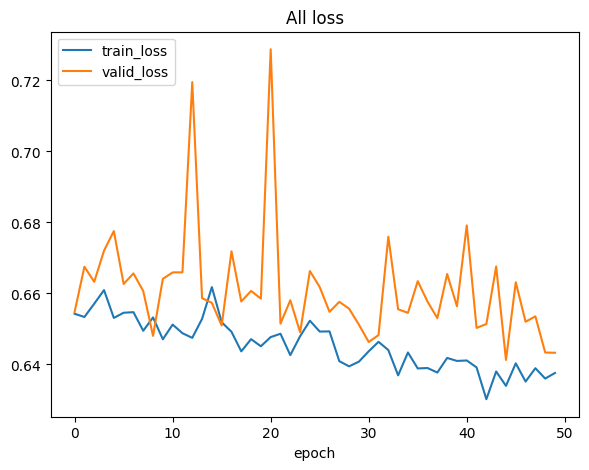

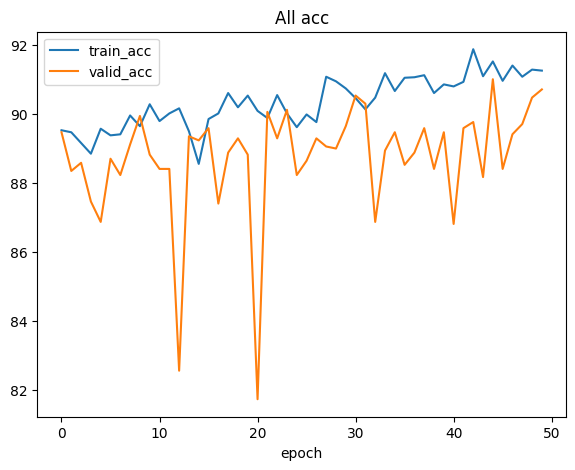

In [14]:
plt_loss_all()
plt_acc_all()

In [15]:
print(predicted[0].item())
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data_utils
TESTDATA_PATH = './noodles_dataset_3k/test/unknown'
for data in os.walk(TESTDATA_PATH):
  test_data=data[2]
test_transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225])
    ])
class Custom_testset(Dataset):
    def __init__(self,testData,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.images = testData
        #self.label = trainLabel
        self.transform = transform

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.images[index]
        img = Image.open(imgpath).convert('RGB')

        if self.transform:
          img = self.transform(img)

        return img

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.images)

def trueclass(num):
  if num==0:
    return 0
  elif num==1:
    return 1
  elif num==2:
    return 2

imgpath=[]
prediction=[]
for photo in test_data:
  path_img = os.path.join(TESTDATA_PATH,photo)
  imgpath.append(path_img)
# print('id = ',test_data)
test_set = Custom_testset(imgpath,test_transform)
testloader = DataLoader(test_set, batch_size=1 , shuffle=False, num_workers = 0)
for images in testloader:
    print('Image batch dimensions:', images.shape)
    break

#images = np.transpose(images, (1,2,0))
for images in testloader:
  #print('image = ',images)
  images=images.to(device)
  output = model(images)
  predicted = torch.argmax(output,dim=1)
  #print('Image predicted label = :', predicted.item())
  prediction=np.append(prediction,trueclass(predicted.item()))

2
Image batch dimensions: torch.Size([1, 3, 224, 224])


In [16]:
prediction_lst=prediction.tolist()
for i in range(len(prediction_lst)):
  prediction_lst[i] = int(prediction_lst[i])
test_data_num=[]
for i in range(len(test_data)):
  test_data_num.append(i)

example={'ID':test_data_num,
      'Target':prediction_lst}
df = pd.DataFrame(example)
print(df)

df.to_csv('./result.csv',index=False)

      ID  Target
0      0       1
1      1       2
2      2       0
3      3       1
4      4       2
..   ...     ...
995  995       0
996  996       0
997  997       2
998  998       1
999  999       0

[1000 rows x 2 columns]
